In [1]:
# Setup & Data Loading

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# -----------------------------------------------------------------------------
# 1) Define paths to all “ready” CSV variants created in EDA
# -----------------------------------------------------------------------------
READY_FILE_RAW          = '../data/loan_data_ready_raw.csv'
READY_FILE_LOG          = '../data/loan_data_ready_log.csv'
READY_FILE_MIN_COLUMNS  = '../data/loan_data_ready_minimal.csv'
READY_FILE_FICO_IR      = '../data/loan_data_ready_fico_ir.csv'
READY_FILE_FICO_IR_INQ  = '../data/loan_data_ready_fico_ir_inq.csv'

# -----------------------------------------------------------------------------
# 2) Select which dataset to use for this experiment
#    – Raw:       raw features scaled
#    – Log:       log-transforms + engineered features
#    – Minimal:   top 3 features + flags
#    – FICO_IR:   FICO + interest rate
#    – FICO_IR_INQ: FICO + interest rate + inquiries
# -----------------------------------------------------------------------------
READY_FILE = READY_FILE_FICO_IR_INQ

# -----------------------------------------------------------------------------
# 3) Load the chosen dataset
# -----------------------------------------------------------------------------
df = pd.read_csv(READY_FILE)
print(f"Loaded {READY_FILE}, shape = {df.shape}")
df.head()



Loaded ../data/loan_data_ready_fico_ir_inq.csv, shape = (9578, 4)


,fico,int.rate,inq.last.6mths,not.fully.paid
0,0.688825,-0.139318,-0.716989,0
1,-0.101303,-0.578868,-0.716989,0
2,-0.759742,0.486484,-0.262470,0
3,0.030385,-0.813544,-0.262470,0
4,-1.154806,0.743509,-0.716989,0


In [2]:
# Define features & target from the ready CSV
target_col = 'not.fully.paid'

# Drop raw, untransformed features
# df = df.drop(columns=['days.with.cr.line', 'revol.bal'])

# pick up every remaining column except the target as a feature
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols]
y = df[target_col]

print("Features used:", feature_cols)
print("Target balance:\n", y.value_counts(normalize=True))






Features used: ['fico', 'int.rate', 'inq.last.6mths']
Target balance:
 not.fully.paid
0    0.839946
1    0.160054
Name: proportion, dtype: float64


In [3]:
from sklearn.model_selection import train_test_split

# Use an 80/20 split, stratified on the target
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

print("Train target balance:\n", y_train.value_counts(normalize=True))
print("Test  target balance:\n", y_test.value_counts(normalize=True))





Train target balance:
 not.fully.paid
0    0.83999
1    0.16001
Name: proportion, dtype: float64
Test  target balance:
 not.fully.paid
0    0.83977
1    0.16023
Name: proportion, dtype: float64


In [4]:
# from imblearn.over_sampling import SMOTE
import numpy as np

# --- Commented out SMOTE to switch to class weights ---
# sm = SMOTE(random_state=42)
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Instead, use the original, imbalanced train data:
X_train_res = X_train.astype(np.float32)
y_train_res = y_train.astype(np.float32)
X_test      = X_test.astype(np.float32)
y_test      = y_test.astype(np.float32)

print("Using original train balance (no SMOTE):")
print(y_train_res.value_counts(normalize=True))





Using original train balance (no SMOTE):
not.fully.paid
0.0    0.83999
1.0    0.16001
Name: proportion, dtype: float64


In [5]:
from sklearn.utils import class_weight
import numpy as np

# Compute balanced class weights from the IMBALANCED y_train
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.values
)
class_weights = {0: weights[0], 1: weights[1]}
print("Class weights:", class_weights)


Class weights: {0: 0.5952454940957116, 1: 3.124796084828711}


In [6]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def make_model(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics= [keras.metrics.AUC(name='auc'),
                 keras.metrics.Recall(name='sensitivity')]
    )
    return model

input_dim = X_train_res.shape[1]
model     = make_model(input_dim)
model.summary()




2025-06-07 17:06:55.330726: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-06-07 17:06:55.330748: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-07 17:06:55.330753: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-07 17:06:55.330768: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-07 17:06:55.330778: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,369 (9.25 KB)

 Trainable params: 2,369 (9.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# history = model.fit(
#     X_train_res, y_train_res,  # old SMOTE‐resampled data
#     validation_split=0.2,
#     epochs=20,
#     batch_size=256
# )

# New: train using class weights on IMBALANCED data
history = model.fit(
    X_train_res,  # which is now X_train.astype(np.float32)
    y_train_res,  # which is now y_train.astype(np.float32)
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    class_weight=class_weights
)





Epoch 1/20


2025-06-07 17:06:55.668125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - auc: 0.5741 - loss: 0.6987 - sensitivity: 0.5492 - val_auc: 0.6683 - val_loss: 0.6758 - val_sensitivity: 0.6426
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6237 - loss: 0.6760 - sensitivity: 0.5606 - val_auc: 0.6657 - val_loss: 0.6723 - val_sensitivity: 0.6298
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6296 - loss: 0.6878 - sensitivity: 0.5747 - val_auc: 0.6638 - val_loss: 0.6721 - val_sensitivity: 0.6298
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6226 - loss: 0.6869 - sensitivity: 0.5884 - val_auc: 0.6659 - val_loss: 0.6705 - val_sensitivity: 0.6340
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6352 - loss: 0.6768 - sensitivity: 0.5687 - val_auc: 0.6671 - val_loss: 0.6664 - val_sensitivity: 0.6213
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6340 - loss: 0.6787 - sensitivity: 0.5543 - val_auc: 0.6653 - val_loss: 0.6673 - val_sensitivity: 0.6298
Epoch 7/20
24/24 ━━━━

In [8]:
loss, auc, sensitivity = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss={loss:.4f}, AUC={auc:.4f}, Sensitivity={sensitivity:.4f}")



Test loss=0.6752, AUC=0.6537, Sensitivity=0.6221


In [9]:
from sklearn.metrics import accuracy_score

# predicted probabilities
y_pred_prob = model.predict(X_test)

# Convert to class labels using 0.5 cutoff
y_pred = (y_pred_prob >= 0.5).astype(int).reshape(-1)

# Compute accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}")


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Test accuracy: 0.5997


In [10]:
from sklearn.metrics import confusion_matrix
import numpy as np

def metrics_at_thresh(y_true, y_prob, thresh):
    """
    Returns sensitivity (recall), specificity, and accuracy
    at a given probability threshold.
    """
    y_pred = (y_prob >= thresh).astype(int).reshape(-1)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy    = (tp + tn) / (tp + tn + fp + fn)
    return sensitivity, specificity, accuracy

print("Thresh  Sensitivity  Specificity  Accuracy")
for t in np.arange(0.1, 0.91, 0.05):
    sens, spec, acc = metrics_at_thresh(y_test, y_pred_prob, t)
    print(f"{t:5.2f}    {sens:10.3f}    {spec:10.3f}    {acc:8.3f}")


Thresh  Sensitivity  Specificity  Accuracy
 0.10         1.000         0.000       0.160
 0.15         1.000         0.000       0.160
 0.20         0.997         0.022       0.178
 0.25         0.984         0.079       0.224
 0.30         0.954         0.167       0.293
 0.35         0.915         0.251       0.358
 0.40         0.840         0.349       0.427
 0.45         0.736         0.467       0.510
 0.50         0.622         0.595       0.600
 0.55         0.495         0.699       0.666
 0.60         0.358         0.805       0.733
 0.65         0.241         0.890       0.786
 0.70         0.173         0.939       0.816
 0.75         0.114         0.966       0.830
 0.80         0.068         0.986       0.839
 0.85         0.046         0.989       0.838
 0.90         0.020         0.993       0.837


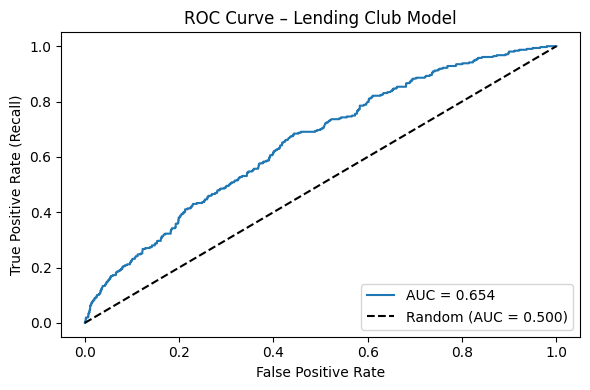

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Compute FPR, TPR, and thresholds for ROC
fpr, tpr, roc_thresh = roc_curve(y_test, y_pred_prob)
roc_auc_val = auc(fpr, tpr)

# 2. Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_val:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.500)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – Lending Club Model")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


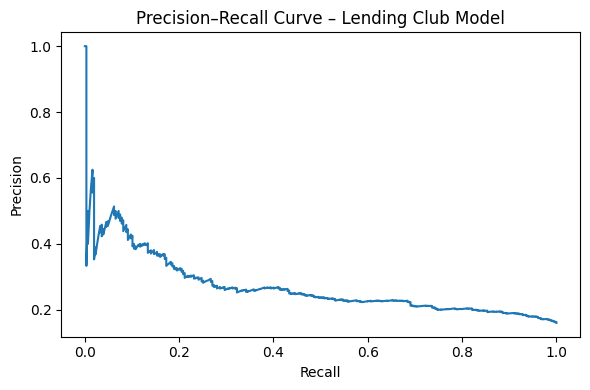

In [12]:
from sklearn.metrics import precision_recall_curve

# 1. Compute precision, recall, and thresholds
precision, recall, pr_thresh = precision_recall_curve(y_test, y_pred_prob)

# 2. Plot the PR curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Lending Club Model")
plt.tight_layout()
plt.show()


In [13]:
# === Hyperparameter Grid Search (Manual) ===

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import pandas as pd

# 1) Define the small grid of hyperparameters
first_layers  = [64, 128]
second_layers = [32, 64]
dropout_pairs = [(0.2, 0.2), (0.3, 0.2)]

results = []

# 2) Loop over each combination
for u1 in first_layers:
    for u2 in second_layers:
        for d1, d2 in dropout_pairs:

            # Build a variant of the model
            def make_model_hp(input_dim):
                m = keras.Sequential([
                    layers.Input(shape=(input_dim,)),
                    layers.Dense(u1, activation='relu',
                                 kernel_regularizer=regularizers.l2(1e-4)),
                    layers.Dropout(d1),
                    layers.Dense(u2, activation='relu',
                                 kernel_regularizer=regularizers.l2(1e-4)),
                    layers.Dropout(d2),
                    layers.Dense(1, activation='sigmoid'),
                ])
                m.compile(
                    optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=[keras.metrics.AUC(name='auc'),
                             keras.metrics.Recall(name='sensitivity')]
                )
                return m

            # Instantiate & train
            model_hp = make_model_hp(X_train_res.shape[1])
            model_hp.fit(
                X_train_res, y_train_res,
                validation_split=0.2,
                epochs=20,
                batch_size=256,
                class_weight=class_weights,
                verbose=0
            )

            # Evaluate on the test set
            loss, auc_val, sens_val = model_hp.evaluate(X_test, y_test, verbose=0)

            # Record the results
            results.append({
                'first_layer': u1,
                'second_layer': u2,
                'dropout1': d1,
                'dropout2': d2,
                'test_auc': auc_val,
                'test_sensitivity': sens_val
            })

# 3) Summarize and display the results
df_results = pd.DataFrame(results).sort_values('test_auc', ascending=False)
print(df_results)


   first_layer  second_layer  dropout1  dropout2  test_auc  test_sensitivity
6          128            64       0.2       0.2  0.655935          0.573290
3           64            64       0.3       0.2  0.655790          0.576547
1           64            32       0.3       0.2  0.655568          0.612378
4          128            32       0.2       0.2  0.655396          0.628664
5          128            32       0.3       0.2  0.655322          0.644951
0           64            32       0.2       0.2  0.654691          0.609121
2           64            64       0.2       0.2  0.654199          0.579805
7          128            64       0.3       0.2  0.653996          0.612378


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# === Final Model: 64→64 with dropout (0.3,0.2), tuned for sensitivity ===

def make_model_final(input_dim):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid'),
    ])
    m.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc'),
                 keras.metrics.Recall(name='sensitivity')]
    )
    return m

# Instantiate
model_final = make_model_final(X_train_res.shape[1])

# Use EarlyStopping to avoid overfitting
early_stop = EarlyStopping(
    monitor='val_sensitivity',  # we care most about recall
    mode='max',
    patience=5,
    restore_best_weights=True
)

# Train for up to 40 epochs
history_final = model_final.fit(
    X_train_res, y_train_res,
    validation_split=0.2,
    epochs=40,
    batch_size=256,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on test
loss_f, auc_f, sens_f = model_final.evaluate(X_test, y_test, verbose=0)
print(f"Final Test loss={loss_f:.4f}, AUC={auc_f:.4f}, Sensitivity={sens_f:.4f}")


Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.5287 - loss: 0.7077 - sensitivity: 0.5017 - val_auc: 0.6663 - val_loss: 0.6869 - val_sensitivity: 0.6468
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6234 - loss: 0.6830 - sensitivity: 0.5630 - val_auc: 0.6635 - val_loss: 0.6740 - val_sensitivity: 0.6255
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6283 - loss: 0.6762 - sensitivity: 0.5849 - val_auc: 0.6664 - val_loss: 0.6704 - val_sensitivity: 0.6298
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6454 - loss: 0.6736 - sensitivity: 0.5848 - val_auc: 0.6652 - val_loss: 0.6697 - val_sensitivity: 0.6213
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6341 - loss: 0.6800 - sensitivity: 0.5706 - val_auc: 0.6661 - val_loss: 0.6733 - val_sensitivity: 0.6340
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6040 - loss: 0.6986 - sensitivity: 0.5254 - val_auc: 0.6665 - val_loss: 0.6808 - val_sensitivity: 0.6383
Final Test